In [1]:
from keras.datasets import imdb
import tensorflow as tf

Using TensorFlow backend.


In [2]:
print(tf.__version__)

1.12.0


In [3]:
from __future__ import print_function

In [4]:
from tensorflow.python.ops import rnn,rnn_cell
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import numpy as np
print(np.__version__)

1.16.2


In [6]:
(X_train,y_train),(X_test,y_test) = imdb.load_data(path="imdb_full.pkl",
                                                  num_words=None,
                                                  skip_top=0,
                                                  maxlen=None,
                                                  seed=113,
                                                  start_char=1,
                                                  oov_char=2,
                                                  index_from=3) 

In [7]:
t = [item for sublist in X_train for item in sublist] 

In [8]:
vocabulary = len(set(t)) + 1 

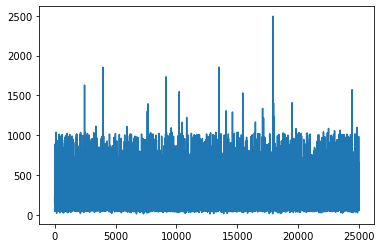

In [9]:
a = [len(x) for x in X_train]
plt.plot(a) 

In [10]:
max_length  = 200 
x_filter = []
y_filter = []

for i in range(len(X_train)):
    if len(X_train[i]) < max_length:
        a = len(X_train[i])
        X_train[i] = X_train[i] + [0] * (max_length - a)
        x_filter.append(X_train[i])
        y_filter.append(y_train[i])
    elif len(X_train[i]) > max_length:
        X_train[i] = X_train[i][0:max_length] 

In [11]:
# declaring the hyper params
embedding_size = 100
n_hidden = 200 
learning_rate = 0.06 
training_iters = 100000 
batch_size = 32 
beta = 0.0001 

In [12]:
n_steps = max_length
n_classes = 2 
da = 350 
r =30 
display_step = 10 
hidden_units = 3000 

In [13]:
y_train = np.asarray(pd.get_dummies(y_filter))
X_train = np.asarray([np.asarray(g) for g in x_filter]) 

In [14]:
logs_path = './recent_logs'

In [15]:
class DataIterator:
    def __init__(self,data1,data2,batch_size):
        self.data1 = data1
        self.data2 = data2
        self.batch_size = batch_size
        self.iter = self.make_random_iter()
        
    def next_batch(self):
        try:
            idxs = next(self.iter)
        except StopIteration:
            self.iter = self.make_random_iter()
            idxs = next(self.iter)
        X = [self.data1[i] for i in idxs]
        Y = [self.data2[i] for i in idxs]
        
        X = np.array(X)
        Y = np.array(Y)
        return X,Y
    
    def make_random_iter(self):
        splits = np.arange(self.batch_size,len(self.data1),self.batch_size)
        it = np.split(np.random.permutation(range(len(self.data1))),splits)[:-1]
        return iter(it) 

In [16]:
with tf.name_scope("weights"):
    Win = tf.Variable(tf.random_uniform([n_hidden*r,hidden_units],-1/np.sqrt(n_hidden),1/np.sqrt(n_hidden)),name='W-input')
    Wout = tf.Variable(tf.random_uniform([hidden_units,n_classes],-1/np.sqrt(hidden_units),1/np.sqrt(hidden_units)),name='W-out')
    Ws1 = tf.Variable(tf.random_uniform([da,n_hidden],1/np.sqrt(da)),name='Ws1')
    Ws2 = tf.Variable(tf.random_uniform([r,da],-1/np.sqrt(r)),name='Ws2')

In [17]:
with tf.name_scope('biases'):
    biasesout = tf.Variable(tf.random_normal([n_classes]),name='biases-out')
    biasesin = tf.Variable(tf.random_normal([hidden_units]),name='biases-in')

In [18]:
with tf.name_scope('input'):
    x = tf.placeholder("int32",[32,max_length],name='x-input')
    y = tf.placeholder("int32",[32,2],name='y-input')

In [19]:
with tf.name_scope('embedding'):
    embeddings = tf.Variable(tf.random_uniform([vocabulary,embedding_size],-1,1),name='embeddings')
    embed = tf.nn.embedding_lookup(embeddings,x) 

In [20]:
def length(sequence):
    used = tf.sign(tf.reduce_max(tf.abs(sequence),reduction_indices=2))
    
    length = tf.reduce_sum(used,reduction_indices=1)
    length = tf.cast(length,tf.int32)
    return length

In [21]:
with tf.variable_scope('forward',reuse=True):
    lstm_fw_cell = tf.nn.rnn_cell.LSTMCell(n_hidden)

In [22]:
with tf.name_scope('model'):
    outputs,states = rnn.dynamic_rnn(lstm_fw_cell,embed,sequence_length=length(embed),dtype=tf.float32,time_major=False)
    h = tf.nn.tanh(tf.transpose(tf.reshape(tf.matmul(Ws1,tf.reshape(outputs,[n_hidden,batch_size*n_steps])),
                                          [da,batch_size,n_steps]),[1,0,2]))
    a = tf.reshape(tf.matmul(Ws2,tf.reshape(h,[da,batch_size*n_steps])),[batch_size,r,n_steps])
    def fn3(a,x):
        return tf.nn.softmax(x)
    h3 = tf.scan(fn3,a) 

In [23]:
with tf.name_scope('flattening'):
    h4 = tf.matmul(h3,outputs)
    last = tf.reshape(h4,[-1,r*n_hidden]) 

In [24]:
with tf.name_scope('MLP'):
    tf.nn.dropout(last,.5,noise_shape=None,seed=None,name=None)
    pred1 = tf.nn.sigmoid(tf.matmul(last,Win)+biasesin)
    pred = tf.matmul(pred1,Wout) + biasesout

In [25]:
with tf.name_scope('cross'):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred,labels=y)+beta*tf.nn.l2_loss(Ws2))   

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [26]:
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    gvs = optimizer.compute_gradients(cost)
    capped_gvs = [(tf.clip_by_norm(grad,0.5),var) for grad,var in gvs]
    optimizer.apply_gradients(capped_gvs)
    optimized = optimizer.minimize(cost) 

In [27]:
with tf.name_scope('Accuracy'):
    correct_pred = tf.equal(tf.argmax(pred,1),tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32)) 

In [28]:
tf.summary.scalar("cost",cost)
tf.summary.scalar("accuracy",accuracy) 

<tf.Tensor 'accuracy_1:0' shape=() dtype=string>

In [29]:
summary_op = tf.summary.merge_all() 

In [30]:
train_iter = DataIterator(X_train,y_train,batch_size)
init = tf.global_variables_initializer() 

In [34]:
with tf.Session() as sess:
    sess.run(init)
    
    writer = tf.summary.FileWriter(logs_path,graph=tf.get_default_graph())
    step = 1 
    
    while step * batch_size < training_iters:
        batch_x,batch_y = train_iter.next_batch()
        sess.run(optimized,feed_dict={x:batch_x,y:batch_y})
        
        summary = sess.run(summary_op,feed_dict={x:batch_x,y:batch_y})
        
        writer.add_summary(summary,step * batch_size)
        
        if step % display_step == 2:
            acc = sess.run(accuracy,feed_dict={x:batch_x,y:batch_y})
            
            loss = sess.run(cost, feed_dict= {x:batch_x,y:batch_y})
            print("Iter "+str(step*batch_size) + \
                  ", Minibatch Loss= " + "{:.6f}".format(loss) + \
                  ", Training Accuracy= "+ "{:.2f}".format(acc*100) + "%")
        step += 1 
    print("Optimization Finished!")

Iter 64, Minibatch Loss= 17.535246, Training Accuracy= 50.00%
Iter 384, Minibatch Loss= 44.965031, Training Accuracy= 50.00%
Iter 704, Minibatch Loss= 33.932579, Training Accuracy= 53.12%
Iter 1024, Minibatch Loss= 8.257021, Training Accuracy= 56.25%
Iter 1344, Minibatch Loss= 24.839247, Training Accuracy= 37.50%
Iter 1664, Minibatch Loss= 5.613566, Training Accuracy= 56.25%
Iter 1984, Minibatch Loss= 20.405418, Training Accuracy= 46.88%
Iter 2304, Minibatch Loss= 5.527768, Training Accuracy= 56.25%
Iter 2624, Minibatch Loss= 18.573048, Training Accuracy= 46.88%
Iter 2944, Minibatch Loss= 29.602596, Training Accuracy= 46.88%
Iter 3264, Minibatch Loss= 34.473885, Training Accuracy= 43.75%
Iter 3584, Minibatch Loss= 13.020053, Training Accuracy= 56.25%
Iter 3904, Minibatch Loss= 7.984556, Training Accuracy= 53.12%
Iter 4224, Minibatch Loss= 5.199084, Training Accuracy= 53.12%
Iter 4544, Minibatch Loss= 7.820098, Training Accuracy= 46.88%
Iter 4864, Minibatch Loss= 3.158295, Training Accu

Iter 41024, Minibatch Loss= 1.193390, Training Accuracy= 56.25%
Iter 41344, Minibatch Loss= 11.385191, Training Accuracy= 53.12%
Iter 41664, Minibatch Loss= 4.226768, Training Accuracy= 59.38%
Iter 41984, Minibatch Loss= 0.744679, Training Accuracy= 43.75%
Iter 42304, Minibatch Loss= 8.150616, Training Accuracy= 46.88%
Iter 42624, Minibatch Loss= 8.553251, Training Accuracy= 59.38%
Iter 42944, Minibatch Loss= 2.573560, Training Accuracy= 53.12%
Iter 43264, Minibatch Loss= 14.710289, Training Accuracy= 59.38%
Iter 43584, Minibatch Loss= 12.511387, Training Accuracy= 46.88%
Iter 43904, Minibatch Loss= 19.932281, Training Accuracy= 59.38%
Iter 44224, Minibatch Loss= 5.673762, Training Accuracy= 40.62%
Iter 44544, Minibatch Loss= 21.306601, Training Accuracy= 59.38%
Iter 44864, Minibatch Loss= 15.287939, Training Accuracy= 53.12%
Iter 45184, Minibatch Loss= 0.989928, Training Accuracy= 50.00%
Iter 45504, Minibatch Loss= 8.017136, Training Accuracy= 56.25%
Iter 45824, Minibatch Loss= 3.1851

Iter 81984, Minibatch Loss= 11.568510, Training Accuracy= 50.00%
Iter 82304, Minibatch Loss= 17.280609, Training Accuracy= 50.00%
Iter 82624, Minibatch Loss= 6.370775, Training Accuracy= 50.00%
Iter 82944, Minibatch Loss= 5.910687, Training Accuracy= 53.12%
Iter 83264, Minibatch Loss= 3.990377, Training Accuracy= 65.62%
Iter 83584, Minibatch Loss= 13.615839, Training Accuracy= 65.62%
Iter 83904, Minibatch Loss= 20.126209, Training Accuracy= 59.38%
Iter 84224, Minibatch Loss= 20.488033, Training Accuracy= 50.00%
Iter 84544, Minibatch Loss= 14.598964, Training Accuracy= 50.00%
Iter 84864, Minibatch Loss= 0.943670, Training Accuracy= 53.12%
Iter 85184, Minibatch Loss= 11.788865, Training Accuracy= 53.12%
Iter 85504, Minibatch Loss= 5.947331, Training Accuracy= 62.50%
Iter 85824, Minibatch Loss= 14.755472, Training Accuracy= 50.00%
Iter 86144, Minibatch Loss= 5.578073, Training Accuracy= 53.12%
Iter 86464, Minibatch Loss= 18.994911, Training Accuracy= 50.00%
Iter 86784, Minibatch Loss= 19.